In [1]:
import numpy as np
import keras
from keras.layers import (
    Input, Conv2D, LeakyReLU, MaxPooling2D,
    concatenate, Dropout, Reshape, LSTM, Dense
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

keras.utils.set_random_seed(3)

2024-06-09 06:21:09.960567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 06:21:09.960681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 06:21:10.133608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def get_Xy(data, features=40, k=4, T=100):
    x = np.array(data[:features, :].T)
    R, C = x.shape
    X = np.zeros((R - T + 1, T, C))
    for i in range(T, R + 1):
        X[i - T] = x[i - T:i, :]
    X = X.reshape(X.shape + (1,))
    
    y = np.array(data[-5:, :].T)[T - 1:R]
    y = keras.utils.to_categorical(y[:, k] - 1, 3)
    return X, y

In [3]:
data = np.loadtxt('../input/fi2010/Train_Dst_NoAuction_ZScore_CF_7.txt')

train_data = data[:, :int(data.shape[1] * 0.8)]
val_data = data[:, int(data.shape[1] * 0.8):]
test_data = np.hstack((
    np.loadtxt('../input/fi2010/Test_Dst_NoAuction_ZScore_CF_7.txt'),
    np.loadtxt('../input/fi2010/Test_Dst_NoAuction_ZScore_CF_8.txt'),
    np.loadtxt('../input/fi2010/Test_Dst_NoAuction_ZScore_CF_9.txt'),
))

X_train, y_train = get_Xy(train_data)
X_val, y_val = get_Xy(val_data)
X_test, y_test = get_Xy(test_data)

In [4]:
def make_deeplob(T, features, lstm_units=64):
    inputs = Input(shape=(T, features, 1))
    
    # Convolutional Layer
    conv = Conv2D(16, (1, 2), strides=(1, 2))(inputs)
    conv = LeakyReLU(negative_slope=0.01)(conv)
    conv = Conv2D(16, (4, 1), padding='same')(conv)
    conv = LeakyReLU(negative_slope=0.01)(conv)
    conv = Conv2D(16, (4, 1), padding='same')(conv)
    conv = LeakyReLU(negative_slope=0.01)(conv)

    conv = Conv2D(16, (1, 2), strides=(1, 2))(conv)
    conv = LeakyReLU(negative_slope=0.01)(conv)
    conv = Conv2D(16, (4, 1), padding='same')(conv)
    conv = LeakyReLU(negative_slope=0.01)(conv)
    conv = Conv2D(16, (4, 1), padding='same')(conv)
    conv = LeakyReLU(negative_slope=0.01)(conv)

    conv = Conv2D(16, (1, 10))(conv)
    conv = LeakyReLU(negative_slope=0.01)(conv)
    conv = Conv2D(16, (4, 1), padding='same')(conv)
    conv = LeakyReLU(negative_slope=0.01)(conv)
    conv = Conv2D(16, (4, 1), padding='same')(conv)
    conv = LeakyReLU(negative_slope=0.01)(conv)
    
    # Inception Module
    incp1 = Conv2D(32, (1, 1), padding='same')(conv)
    incp1 = LeakyReLU(negative_slope=0.01)(incp1)
    incp1 = Conv2D(32, (3, 1), padding='same')(incp1)
    incp1 = LeakyReLU(negative_slope=0.01)(incp1)

    incp2 = Conv2D(32, (1, 1), padding='same')(conv)
    incp2 = LeakyReLU(negative_slope=0.01)(incp2)
    incp2 = Conv2D(32, (5, 1), padding='same')(incp2)
    incp2 = LeakyReLU(negative_slope=0.01)(incp2)

    incp3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv)
    incp3 = Conv2D(32, (1, 1), padding='same')(incp3)
    incp3 = LeakyReLU(negative_slope=0.01)(incp3)
    
    concat = concatenate([incp1, incp2, incp3], axis=3)
    incp = Reshape((int(concat.shape[1]), int(concat.shape[3])))(concat)
    incp = Dropout(0.2, noise_shape=(None, 1, int(incp.shape[2])))(incp, training=True)
    
    # LSTM Module and Output
    lstm = LSTM(lstm_units)(incp)
    outputs = Dense(3, activation='softmax')(lstm)
    
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01, epsilon=1),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

deeplob = make_deeplob(X_train.shape[1], X_train.shape[2])
deeplob.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 40,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 20,   │         48 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 100, 20,   │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 20,   │      1,040 │ leaky_re_lu[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 100, 20,   │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 20,   │      1,040 │ leaky_re_lu_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 100, 20,   │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 10,   │        528 │ leaky_re_lu_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 100, 10,   │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 100, 10,   │      1,040 │ leaky_re_lu_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 100, 10,   │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 100, 10,   │      1,040 │ leaky_re_lu_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 100, 10,   │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 100, 1,    │      2,576 │ leaky_re_lu_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 100, 1,    │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 100, 1,    │      1,040 │ leaky_re_lu_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 100, 1,    │          0 │ conv2d_7[0][0]  

 Total params: 60,691 (237.07 KB)

 Trainable params: 60,691 (237.07 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
deeplob.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32, epochs=24
)

Epoch 1/24
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 102s 15ms/step - accuracy: 0.4132 - loss: 1.0432 - val_accuracy: 0.3723 - val_loss: 1.0880
Epoch 2/24
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 88s 14ms/step - accuracy: 0.4310 - loss: 1.0072 - val_accuracy: 0.3929 - val_loss: 1.0642
Epoch 3/24
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 88s 14ms/step - accuracy: 0.4923 - loss: 0.8913 - val_accuracy: 0.5327 - val_loss: 0.8815
Epoch 4/24
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 88s 14ms/step - accuracy: 0.5586 - loss: 0.8340 - val_accuracy: 0.5274 - val_loss: 0.8904
Epoch 5/24
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 89s 14ms/step - accuracy: 0.6067 - loss: 0.7952 - val_accuracy: 0.5679 - val_loss: 0.8658
Epoch 6/24
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 89s 14ms/step - accuracy: 0.6910 - loss: 0.7054 - val_accuracy: 0.6081 - val_loss: 0.8240
Epoch 7/24
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 88s 14ms/step - accuracy: 0.7260 - loss: 0.6492 - val_accuracy: 0.6340 - val_loss: 0.7969
Epoch 8/24
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 89s 14ms/step - accuracy: 0.7473 

In [6]:
y_hat = deeplob.predict(X_test)

4359/4359 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step


In [7]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_hat, axis=1)

print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, digits=3))

accuracy: 0.7880606217022252
              precision    recall  f1-score   support

           0      0.788     0.753     0.770     47915
           1      0.842     0.821     0.832     48050
           2      0.733     0.790     0.761     43523

    accuracy                          0.788    139488
   macro avg      0.788     0.788     0.788    139488
weighted avg      0.790     0.788     0.788    139488



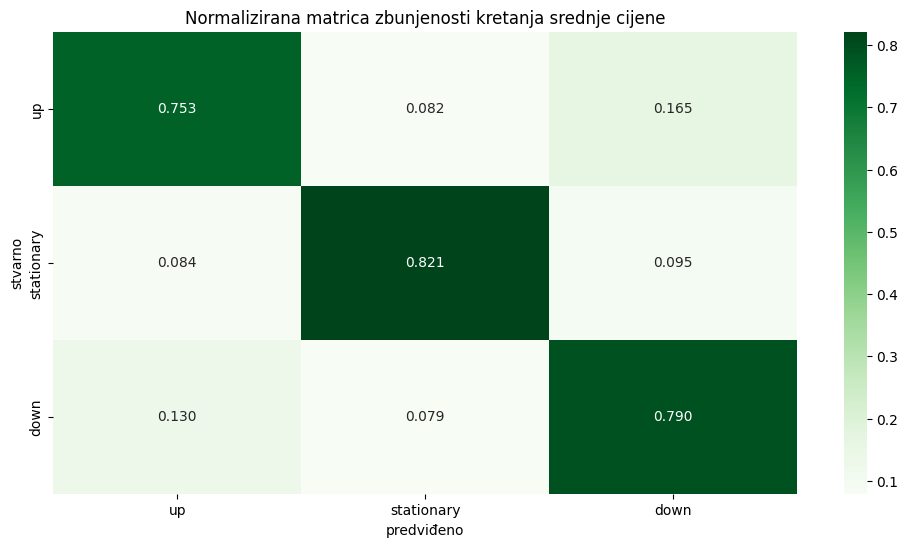

In [8]:
def plt_confusion_matrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize = (12, 6))
    
    plt.title('Normalizirana matrica zbunjenosti kretanja srednje cijene')
    class_labels = ['up', 'stationary', 'down']
    sns.heatmap(
        confusion_matrix(y_true, y_pred, normalize='true'),
        annot=True,
        cmap='Greens',
        fmt='.3f',
        xticklabels=class_labels,
        yticklabels=class_labels
    ).set(xlabel='predviđeno', ylabel='stvarno')

plt_confusion_matrix(y_true, y_pred)